In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm
import seaborn as sns
import joblib
import os

from impyute.imputation.cs import fast_knn
from sklearn.impute import KNNImputer, SimpleImputer
from scipy import stats
from scipy.stats import chi2_contingency
from itertools import combinations
from sklearn.metrics import matthews_corrcoef
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from joblib import load
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

## bald_probability

In [3]:
# 폰트 파일의 경로 지정
font_path = r'C:\Windows\Fonts\gulim.ttc'

In [92]:
# matplotlib 패키지에 한글 폰트 설정
myFont = fm.FontProperties(fname = font_path).get_name()
mpl.rc('font', family = myFont)

In [93]:
data_file = './DATA/bald_probability.csv'

In [94]:
baldDF = pd.read_csv(data_file)
baldDF.shape

(7917, 14)

In [95]:
baldDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7917 entries, 0 to 7916
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   age            7832 non-null   float64
 1   gender         7840 non-null   object 
 2   job_role       6600 non-null   object 
 3   province       7831 non-null   object 
 4   salary         7843 non-null   float64
 5   is_married     7845 non-null   float64
 6   is_hereditary  7828 non-null   float64
 7   weight         7861 non-null   float64
 8   height         7843 non-null   float64
 9   shampoo        7858 non-null   object 
 10  is_smoker      7847 non-null   float64
 11  education      7847 non-null   object 
 12  stress         7853 non-null   float64
 13  bald_prob      7838 non-null   float64
dtypes: float64(9), object(5)
memory usage: 866.0+ KB


In [96]:
baldDF.drop_duplicates().shape[0] == sum(~baldDF.duplicated())

True

In [97]:
# 중복 데이터 82개 삭제
baldDF = baldDF.drop_duplicates()
baldDF.shape

(7835, 14)

In [98]:
# bald_prob가 결측된 데이터 삭제
baldDF = baldDF.dropna(subset = ['bald_prob'])
baldDF.shape

(7757, 14)

In [99]:
baldDF.nunique()

age                70
gender              2
job_role            3
province           34
salary           7686
is_married          2
is_hereditary       2
weight           7701
height           7685
shampoo             5
is_smoker           2
education           6
stress             10
bald_prob        7659
dtype: int64

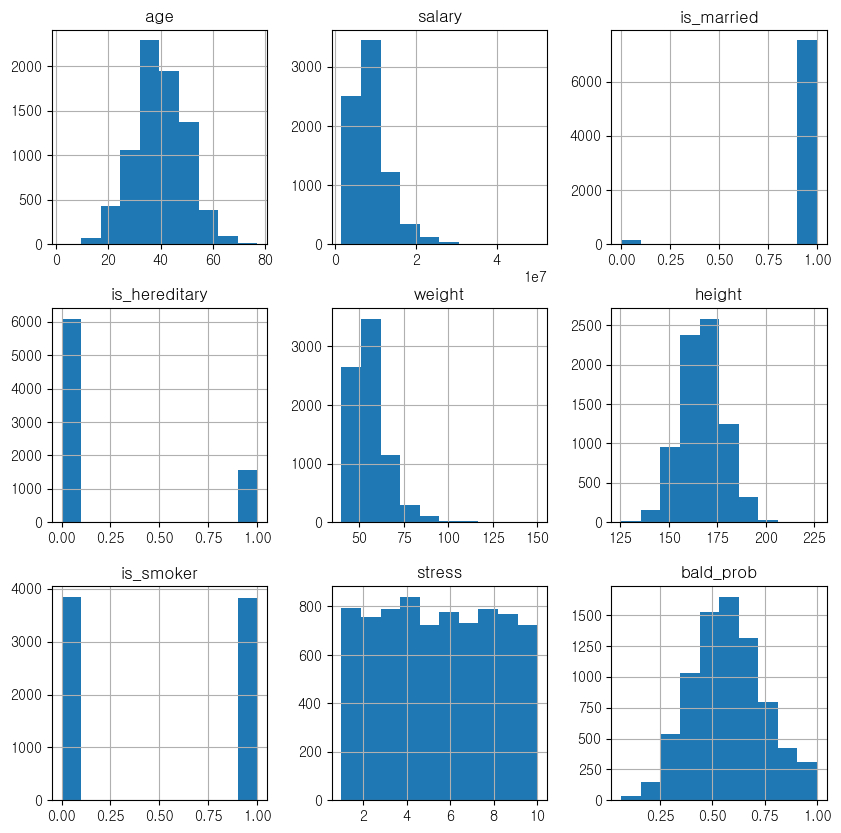

In [100]:
# 수치형 데이터 히스토그램
baldDF.hist(figsize = (10, 10))
plt.show()

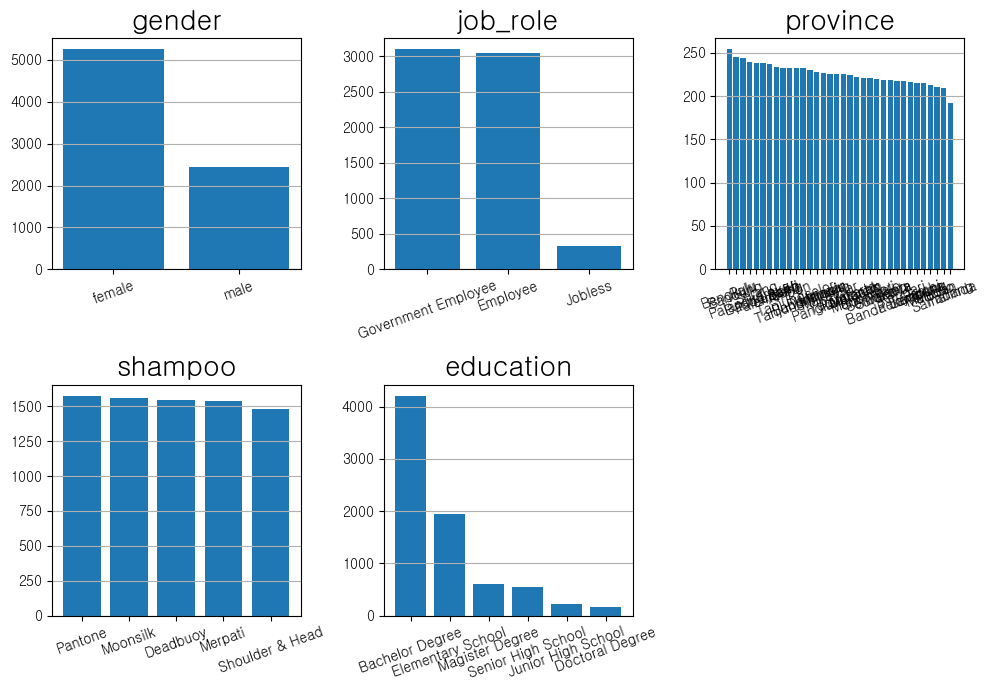

In [101]:
# 범주형 데이터 히스토그램
ind = 1
plt.figure(figsize = (10, 7))
for col in baldDF.select_dtypes('object').columns:
    plt.subplot(2, 3, ind)
    plt.title(col, size = 20)
    plt.bar(range(baldDF[col].nunique()), baldDF[col].value_counts())
    plt.xticks(range(baldDF[col].nunique()), baldDF[col].dropna().unique(), rotation = 20)  # unique() 함수는 결측치도 카운트한다.
    plt.grid(axis = 'y')
    ind += 1

plt.tight_layout()
plt.show()

In [102]:
# 기혼자만 고려
baldDF = baldDF.drop('is_married', axis = 1)
baldDF.head()

,age,gender,job_role,province,salary,is_hereditary,weight,height,shampoo,is_smoker,education,stress,bald_prob
0,27.0,female,Government Employee,Bengkulu,7.957453e+06,0.0,54.315053,170.428542,Pantone,1.0,Bachelor Degree,5.0,0.605974
1,53.0,female,Government Employee,Bandung,7.633003e+06,0.0,72.873404,165.530097,Pantone,0.0,Bachelor Degree,7.0,0.532860
2,37.0,female,Employee,Bandung,6.637625e+06,0.0,46.321533,154.599388,Moonsilk,0.0,Bachelor Degree,4.0,0.418442
3,36.0,female,Jobless,Palu,3.624871e+06,0.0,51.539781,167.340481,Deadbuoy,1.0,Elementary School,9.0,0.804050
4,38.0,male,NaN,Palangkaraya,6.031808e+06,0.0,60.726909,165.514773,Merpati,1.0,Magister Degree,1.0,0.368371


### 데이터 전처리 <hr>

#### 이상치 처리

In [103]:
# Z-score 기반 이상치 탐지 함수

def find_outlier(column_list, scale = 3, df = baldDF):
    for col in column_list:
        mean_value = df[col].mean()
        std_value = df[col].std()

        base =scale
        z_data = (df[col] - mean_value) / std_value
        mask = z_data.abs() > base
        print(f'{col} 특성의 이상치 개수 : {z_data[mask].count()}개\n')

In [104]:
find_outlier(['age', 'height'])

age 특성의 이상치 개수 : 17개

height 특성의 이상치 개수 : 23개



In [105]:
baldDF.shape

(7757, 13)

In [106]:
# Z-score 기반 이상치 제거 함수
def delete_outlier(column_list, scale = 3, df = baldDF):
    del_index_list = []
    for col in column_list:
        mean_value = df[col].mean()
        std_value = df[col].std()
        base = scale
        z_data = (df[col] - mean_value) / std_value
        mask = z_data.abs() > base
        index_list = list(df[mask].index)
        del_index_list += index_list
    
    del_index_list = list(set(del_index_list))
    df = df.drop(del_index_list)
    df.reset_index(drop = True, inplace = True)
    
    return df

In [107]:
# Z-score 기반으로 age, height 이상치가 포함된 데이터 삭제
baldDF = delete_outlier(['age', 'height'])

In [108]:
# height 이상치가 포함된 데이터 삭제 확인
baldDF.shape

(7717, 13)

In [109]:
# 사분위수 기반 이상치 탐지 함수
def find_outlier2(column_list, scale = 1.5, df = baldDF):
    for col in column_list:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        
        # 이상치로 판단할 기준이 되는 값
        lower = q1 - scale*iqr
        upper = q3 + scale*iqr
        mask = (df[col] < lower) | (df[col] > upper) 
        
        print(f'{col} 특성의 이상치 개수 : {df[col][mask].count()}개\n')

In [110]:
# 사분위수 기반
find_outlier2(['salary', 'weight'])

salary 특성의 이상치 개수 : 277개

weight 특성의 이상치 개수 : 276개



In [111]:
# 사분위수 기반 이상치 제거 함수
def delete_outlier2(column_list, scale = 1.5, df = baldDF):
    del_index_list = []
    for column in column_list:
        q1 = df[column].quantile(0.25)
        q3 = df[column].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - scale*iqr
        upper = q3 + scale*iqr
        mask = (df[column] > upper) | (df[column] < lower)
        index_list = list(df[mask].index)
        del_index_list += index_list
    
    del_index_list = list(set(del_index_list))
    df = df.drop(del_index_list)
    df.reset_index(drop = True, inplace = True)
    
    return df

In [112]:
# 사분위수 기반으로 salary, weight 이상치가 포함된 데이터 삭제
baldDF = delete_outlier2(['salary', 'weight'])

In [113]:
# 사분위수 기반으로 salary, weight 이상치가 포함된 데이터 삭제 확인
baldDF.shape

(7175, 13)

#### 결측치 처리

In [114]:
# 피처별 결측치 개수
baldDF.isna().sum()

age                80
gender             68
job_role         1192
province           81
salary             68
is_hereditary      82
weight             54
height             62
shampoo            55
is_smoker          64
education          65
stress             55
bald_prob           0
dtype: int64

- bald_prob 결측치 처리 => 위에서 결측치를 포함한 데이터 삭제

- age 결측치 처리

In [115]:
baldDF.age.value_counts()

age
37.0    342
41.0    298
40.0    289
38.0    285
35.0    283
43.0    270
36.0    269
39.0    267
42.0    259
44.0    258
34.0    243
45.0    243
33.0    228
47.0    221
46.0    213
32.0    206
48.0    196
31.0    194
49.0    186
30.0    172
50.0    165
29.0    164
51.0    154
28.0    135
27.0    123
53.0    120
52.0    119
26.0    104
54.0    101
25.0     90
56.0     89
55.0     77
24.0     76
23.0     69
22.0     65
57.0     59
21.0     57
20.0     54
58.0     48
19.0     36
60.0     30
59.0     29
17.0     23
18.0     21
64.0     17
63.0     17
61.0     16
16.0     16
62.0     15
65.0     13
11.0     11
15.0     10
69.0      9
14.0      9
13.0      7
66.0      6
12.0      6
67.0      5
10.0      4
68.0      4
Name: count, dtype: int64

- gender 결측치 처리 => 남자와 여자의 키, 몸무게 분포가 비슷하여 키 또는 몸무게로 성별 결측치 채우기 어렵다. 교육 수준으로도 판별하기 어렵다.

In [116]:
baldDF.age.isna().sum()

80

In [117]:
#baldDF.groupby('gender')
maleDF = baldDF.groupby('gender').get_group('male')
femaleDF = baldDF.groupby('gender').get_group('female')
print(f'male => {maleDF.shape[0]}개\n\nfemale = > {femaleDF.shape[0]}개')
maleDF['height'].describe(), femaleDF['height'].describe()

male => 4866개

female = > 2241개


(count    4825.000000
 mean      166.818752
 std        10.437423
 min       134.489227
 25%       159.609281
 50%       166.843629
 75%       174.002593
 max       197.528947
 Name: height, dtype: float64,
 count    2220.000000
 mean      166.439440
 std        10.517874
 min       135.286161
 25%       159.385961
 50%       166.465553
 75%       173.342696
 max       197.420836
 Name: height, dtype: float64)

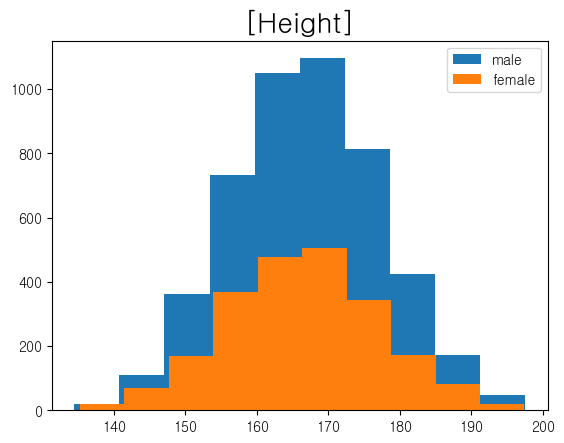

In [118]:
# 남자 키와 여자 키 비교
plt.hist(maleDF['height'], label = 'male')
plt.hist(femaleDF['height'], label = 'female')
plt.title('[Height]', size = 20)
plt.legend()
plt.show()

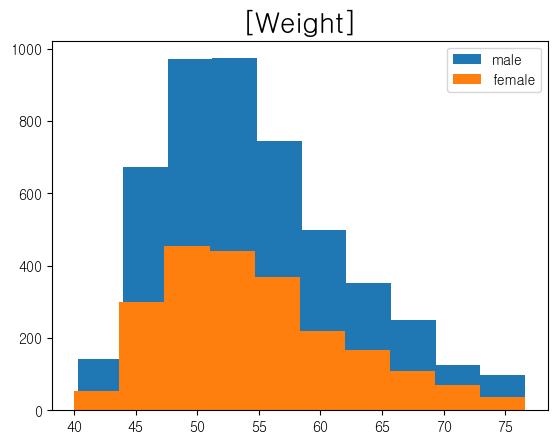

In [119]:
# 남자 몸무게와 여자 몸무게 비교
plt.hist(maleDF['weight'], label = 'male')
plt.hist(femaleDF['weight'], label = 'female')
plt.title('[Weight]', size = 20)
plt.legend()
plt.show()

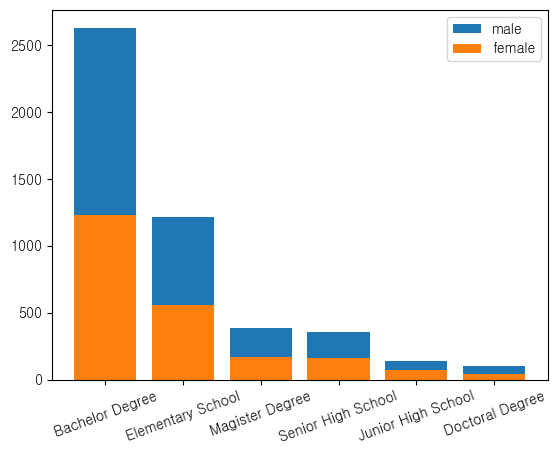

In [120]:
plt.bar(range(maleDF['education'].nunique()), maleDF['education'].value_counts(), label = 'male')
plt.bar(range(femaleDF['education'].nunique()), femaleDF['education'].value_counts(), label = 'female')
plt.xticks(range(baldDF['education'].nunique()), baldDF['education'].dropna().unique(), rotation = 20)
plt.legend()
plt.show()

- job_role 결측치 처리

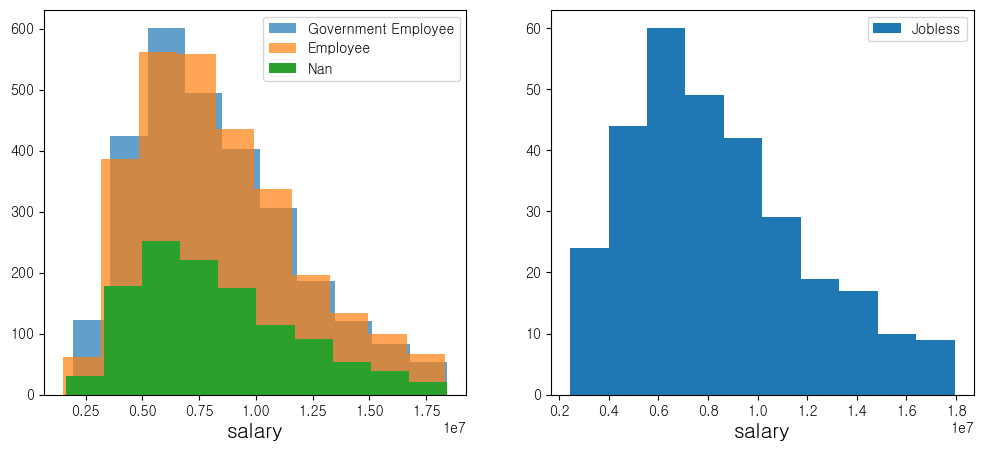

In [121]:
df2 = baldDF[baldDF.job_role.isna()]  # job_role이 결측치인 데이터만 추출
job = baldDF.groupby('job_role')
plt.figure(figsize = (12, 5))
plt.subplot(1, 2, 1)
for col in ['Government Employee', 'Employee']:
    df = job.get_group(col)
    salary = df.salary
    plt.hist(salary, label = f'{col}', alpha = 0.7)
plt.hist(df2.salary, label = 'Nan')
plt.xlabel('salary', size = 15)
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(job.get_group('Jobless').salary, label = 'Jobless')
plt.xlabel('salary', size = 15)
plt.legend()
plt.show()

In [122]:
# 결측값 
baldDF['job_role'] = baldDF['job_role'].fillna('etc')

In [123]:
baldDF.job_role.isna().sum()

0

- province 결측치 처리

In [124]:
baldDF.province.value_counts()

province
Kupang            234
Tanjungselor      229
Makassar          220
Mamuju            220
Banjarmasin       220
Mataram           219
Manado            217
Denpasar          217
Tanjung Pinang    214
Bengkulu          214
Semarang          213
Jakarta           212
Ambon             212
Gorontalo         212
Pangkalpinang     211
Serang            210
Jayapura          210
Samarinda         207
Pontianak         207
Banda Lampung     206
Yogyakarta        205
Pekanbaru         205
Kendari           205
Padang            204
Jambi             203
Manokwari         203
Palembang         202
Medan             201
Banda Aceh        200
Palu              200
Palangkaraya      199
Bandung           194
Sofifi            190
Surabaya          179
Name: count, dtype: int64

In [125]:
baldDF.province.isna().sum()

81

- salary, weight, height 결측치 처리

In [126]:
imputer = KNNImputer(n_neighbors = 5)  # 이웃수는 나중에 조정
imputed = imputer.fit_transform(baldDF[['salary', 'weight', 'height']])
df_imputed = pd.DataFrame(imputed, columns = ['salary', 'weight', 'height'])
df_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7175 entries, 0 to 7174
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   salary  7175 non-null   float64
 1   weight  7175 non-null   float64
 2   height  7175 non-null   float64
dtypes: float64(3)
memory usage: 168.3 KB


In [127]:
df_imputed

,salary,weight,height
0,7.957453e+06,54.315053,170.428542
1,7.633003e+06,72.873404,165.530097
2,6.637625e+06,46.321533,154.599388
3,3.624871e+06,51.539781,167.340481
4,6.031808e+06,60.726909,165.514773
...,...,...,...
7170,4.286318e+06,46.893444,169.880171
7171,8.646146e+06,53.878714,170.122857
7172,6.850066e+06,64.171294,161.384804
7173,1.204960e+07,55.217752,179.602130


In [128]:
for col in ['salary', 'weight', 'height']:
    baldDF[col] = df_imputed[col].values

In [129]:
# 결측치 채워졌는지 확인
baldDF.isna().sum()

age              80
gender           68
job_role          0
province         81
salary            0
is_hereditary    82
weight            0
height            0
shampoo          55
is_smoker        64
education        65
stress           55
bald_prob         0
dtype: int64

In [130]:
# def optimize_k(data, target):
#     errors = []

#     for k in range(1, 20, 2):
#         imputer = KNNImputer(n_neighbors=k)
#         imputed = imputer.fit_transform(data)
#         df_imputed = pd.DataFrame(imputed, columns=df.columns)

#         X = df_imputed.drop(target, axis=1)
#         y = df_imputed[target]
#         X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#         model = RandomForestRegressor()
#         model.fit(X_train, y_train)
#         preds = model.predict(X_test)
#         error = rmse(y_test, preds)

#         errors.append({'K': k, 'RMSE': error})
#     return errors

- is_hereditary 결측치 처리

In [131]:
baldDF.is_hereditary.value_counts()

is_hereditary
0.0    5644
1.0    1449
Name: count, dtype: int64

In [132]:
baldDF.is_hereditary.isna().sum()

82

- shampoo 결측치 처리

In [133]:
baldDF.shampoo.value_counts()

shampoo
Deadbuoy           1470
Moonsilk           1447
Pantone            1426
Shoulder & Head    1410
Merpati            1367
Name: count, dtype: int64

In [134]:
baldDF.shampoo.isna().sum()

55

- is_smoker 결측치 처리

In [135]:
baldDF.is_smoker.value_counts()

is_smoker
1.0    3556
0.0    3555
Name: count, dtype: int64

In [136]:
baldDF.is_smoker.isna().sum()

64

- education 결측치 처리

In [137]:
baldDF.education.value_counts()

education
Bachelor Degree       3898
Senior High School    1795
Magister Degree        552
Junior High School     512
Elementary School      209
Doctoral Degree        144
Name: count, dtype: int64

In [138]:
baldDF.education.isna().sum()

65

- stress 결측치 처리

In [139]:
baldDF.stress.value_counts()

stress
4.0     777
1.0     740
3.0     732
8.0     722
9.0     720
6.0     717
7.0     690
2.0     686
10.0    673
5.0     663
Name: count, dtype: int64

In [140]:
baldDF.stress.isna().sum()

55

- age, gender, province, is_hereditary, shampoo, is_smoker, education, stress 결측치 처리

In [141]:
simp = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
df = baldDF.copy()
df = df[['age', 'gender', 'province', 'is_hereditary', 'shampoo', 'is_smoker', 'education', 'stress']]
df = pd.DataFrame(simp.fit_transform(df), columns = df.columns, index = df.index)
df.isna().sum()

age              0
gender           0
province         0
is_hereditary    0
shampoo          0
is_smoker        0
education        0
stress           0
dtype: int64

In [142]:
# 각 피처의 결측값을 최빈값으로 대체
for col in ['age', 'gender', 'province', 'is_hereditary', 'shampoo', 'is_smoker', 'education', 'stress']:
    baldDF[col] = df[col].values

In [143]:
# 범주형 데이터 피처 중 실수형은 정수형으로 변환
baldDF = baldDF.astype({'age' : int, 'is_hereditary' : int, 'is_smoker' : int, 'stress' : int})

In [144]:
# gender 피처 데이터는 0, 1로 변환
baldDF['gender'] = baldDF['gender'].replace({'female' : 0, 'male' : 1})

C:\Users\user\AppData\Local\Temp\ipykernel_18980\3452699836.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  baldDF['gender'] = baldDF['gender'].replace({'female' : 0, 'male' : 1})


In [145]:
baldDF.education.unique()

array(['Bachelor Degree', 'Elementary School', 'Magister Degree',
       'Senior High School', 'Junior High School', 'Doctoral Degree'],
      dtype=object)

In [146]:
# education 피처 데이터는 학위 순으로 1 ~ 6으로 배정

baldDF['education'] = baldDF['education'].replace({'Elementary School' : 1,
                                                   'Junior High School' : 2,
                                                   'Senior High School' :3,
                                                   'Bachelor Degree' : 4,
                                                   'Magister Degree' : 5,
                                                   'Doctoral Degree' : 6})

C:\Users\user\AppData\Local\Temp\ipykernel_18980\2236647895.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  baldDF['education'] = baldDF['education'].replace({'Elementary School' : 1,


In [147]:
df = baldDF.copy()
lee = LabelEncoder()
lee.fit(df['job_role'])
labels = lee.transform(df['job_role'])

print(df['job_role'].unique())
print(labels[3])
df['job_role']

['Government Employee' 'Employee' 'Jobless' 'etc']
2


0       Government Employee
1       Government Employee
2                  Employee
3                   Jobless
4                       etc
               ...         
7170    Government Employee
7171    Government Employee
7172    Government Employee
7173               Employee
7174               Employee
Name: job_role, Length: 7175, dtype: object

In [148]:
# 남은 범주형 데이터 라벨 인코딩
for col in ['job_role', 'province', 'shampoo']:
    le = LabelEncoder()
    baldDF[col] = le.fit_transform(baldDF[col])

In [149]:
baldDF.head()

,age,gender,job_role,province,salary,is_hereditary,weight,height,shampoo,is_smoker,education,stress,bald_prob
0,27,0,1,5,7.957453e+06,0,54.315053,170.428542,3,1,4,5,0.605974
1,53,0,1,3,7.633003e+06,0,72.873404,165.530097,3,0,4,7,0.532860
2,37,0,0,3,6.637625e+06,0,46.321533,154.599388,2,0,4,4,0.418442
3,36,0,2,22,3.624871e+06,0,51.539781,167.340481,0,1,1,9,0.804050
4,38,1,3,20,6.031808e+06,0,60.726909,165.514773,1,1,5,1,0.368371


In [150]:
baldDF.shape

(7175, 13)

#### 타겟과 수치형 피처 상관계수

In [151]:
def print_feature(nrows, ncols, target, features, corrs, df = baldDF):
    for idx in range(len(features)):
        plt.subplot(nrows, ncols, idx + 1)
        plt.scatter(df[target], df[features[idx]], label = f'corr : {corrs[idx]:.2}', color = 'cornflowerblue')
        plt.xlabel(target, size = 15)
        plt.ylabel(features[idx], size = 15)
        plt.legend()
    plt.tight_layout()
    plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_18980\3791551973.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.scatter(df[target], df[features[idx]], label = f'corr : {corrs[idx]:.2}', color = 'cornflowerblue')


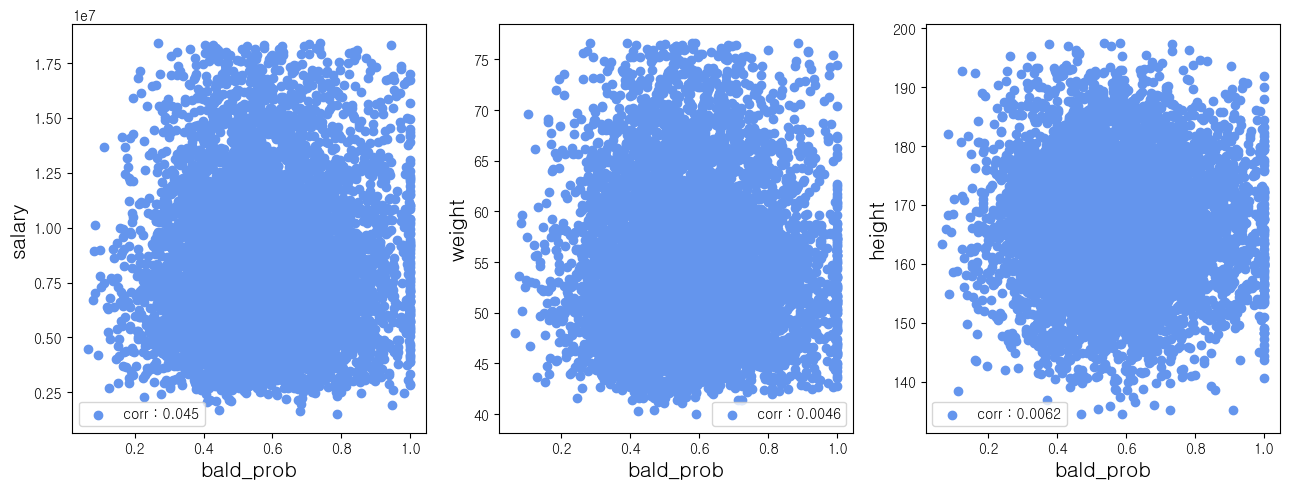

In [152]:
numerical_col = ['salary', 'weight', 'height', 'bald_prob']
corrs = baldDF[numerical_col].corr()['bald_prob']
plt.figure(figsize = (13, 5))
print_feature(1, 3, 'bald_prob', numerical_col[:-1], corrs[:-1], baldDF[numerical_col])

- 타겟과 BMI(체질량지수) 상관계수

In [153]:
baldDF[['weight', 'height']].head()

,weight,height
0,54.315053,170.428542
1,72.873404,165.530097
2,46.321533,154.599388
3,51.539781,167.340481
4,60.726909,165.514773


In [154]:
# 키, 몸무게 결측 데이터 제거
df = baldDF.dropna(subset = ['weight', 'height'])

# 키 데이터 단위(cm)를 m로 변경하기 위해 100으로 나누고 BMI 계산
df['BMI'] = df['weight']/(df['height']/100)**2

In [155]:
df.BMI

0       18.699739
1       26.595926
2       19.380607
3       18.405200
4       22.167037
          ...    
7170    16.249004
7171    18.616236
7172    24.638571
7173    17.118108
7174    15.084130
Name: BMI, Length: 7175, dtype: float64

C:\Users\user\AppData\Local\Temp\ipykernel_18980\3791551973.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.scatter(df[target], df[features[idx]], label = f'corr : {corrs[idx]:.2}', color = 'cornflowerblue')


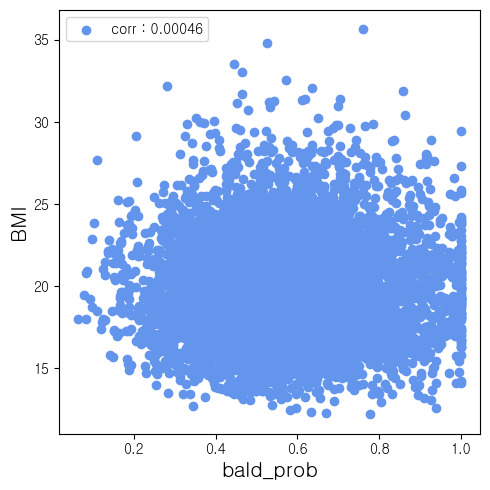

In [156]:
corrs = df[['BMI', 'bald_prob']].corr()['bald_prob']
plt.figure(figsize = (5, 5))
print_feature(1, 1, 'bald_prob', ['BMI'], corrs[:-1], df[['BMI', 'bald_prob']])

#### 타겟과 범주형 데이터 상관계수

In [157]:
# 타겟과 범주형(순서형) 데이터 상관계수
df = baldDF.copy()
df2 = df[['age', 'education', 'stress', 'bald_prob']]
df2.corr(method = 'spearman')

,age,education,stress,bald_prob
age,1.000000,-0.000594,-0.022200,0.364935
education,-0.000594,1.000000,0.012186,0.009470
stress,-0.022200,0.012186,1.000000,0.290789
bald_prob,0.364935,0.009470,0.290789,1.000000


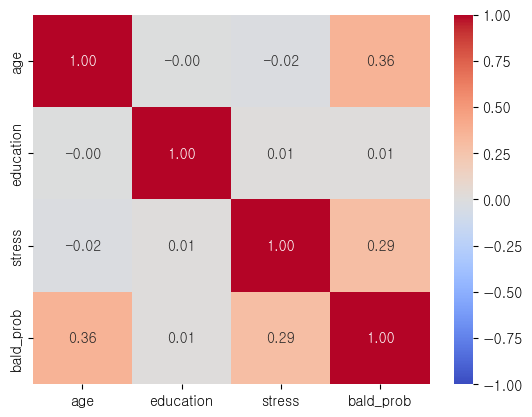

In [158]:
sns.heatmap(df2.corr(method = 'spearman'), annot=True, cmap="coolwarm", vmax=1, vmin=-1, fmt = '.2f')
plt.show()

In [159]:
baldDF.columns

Index(['age', 'gender', 'job_role', 'province', 'salary', 'is_hereditary',
       'weight', 'height', 'shampoo', 'is_smoker', 'education', 'stress',
       'bald_prob'],
      dtype='object')

In [160]:
binary_categorical_list = ['gender', 'is_hereditary', 'is_smoker']
multiple_categorical_list = ['age', 'job_role', 'province', 'shampoo', 'education', 'stress']

In [161]:
baldDF

,age,gender,job_role,province,salary,is_hereditary,weight,height,shampoo,is_smoker,education,stress,bald_prob
0,27,0,1,5,7.957453e+06,0,54.315053,170.428542,3,1,4,5,0.605974
1,53,0,1,3,7.633003e+06,0,72.873404,165.530097,3,0,4,7,0.532860
2,37,0,0,3,6.637625e+06,0,46.321533,154.599388,2,0,4,4,0.418442
3,36,0,2,22,3.624871e+06,0,51.539781,167.340481,0,1,1,9,0.804050
4,38,1,3,20,6.031808e+06,0,60.726909,165.514773,1,1,5,1,0.368371
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7170,52,1,1,16,4.286318e+06,0,46.893444,169.880171,0,1,3,2,0.773141
7171,45,1,1,32,8.646146e+06,0,53.878714,170.122857,3,0,4,2,0.604058
7172,24,1,1,9,6.850066e+06,0,64.171294,161.384804,2,0,3,8,0.502413
7173,29,1,0,20,1.204960e+07,0,55.217752,179.602130,3,1,3,6,0.562664


In [162]:
# 이진 범주형 데이터와 타겟 데이터의 상관계수
coef_dict = {}
for col in binary_categorical_list:
    coef = stats.pointbiserialr(df[col], df.bald_prob).statistic
    coef_dict[col] = coef
    print(f'{col}과 bald_prob의 Biserial coef는 {round(coef, 2)}\n')

gender과 bald_prob의 Biserial coef는 0.26

is_hereditary과 bald_prob의 Biserial coef는 0.43

is_smoker과 bald_prob의 Biserial coef는 0.26



In [163]:
baldDF.columns

Index(['age', 'gender', 'job_role', 'province', 'salary', 'is_hereditary',
       'weight', 'height', 'shampoo', 'is_smoker', 'education', 'stress',
       'bald_prob'],
      dtype='object')

In [164]:
# 다중 범주형 데이터와 타겟 데이터의 상관계수

df = baldDF.copy()
df2 = df[['job_role', 'province', 'shampoo', 'bald_prob']]
df2.corr(method = 'spearman')

,job_role,province,shampoo,bald_prob
job_role,1.000000,0.021559,0.005775,0.030592
province,0.021559,1.000000,-0.019263,-0.012412
shampoo,0.005775,-0.019263,1.000000,0.001726
bald_prob,0.030592,-0.012412,0.001726,1.000000


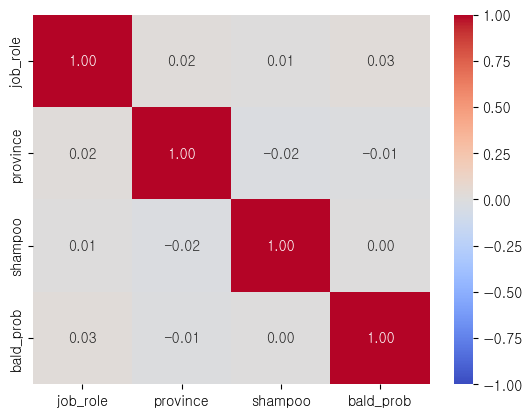

In [165]:
sns.heatmap(df2.corr(method = 'spearman'), annot=True, cmap="coolwarm", vmax=1, vmin=-1, fmt = '.2f')
plt.show()

#### 다중공선성 확인

In [166]:
baldDF.columns

Index(['age', 'gender', 'job_role', 'province', 'salary', 'is_hereditary',
       'weight', 'height', 'shampoo', 'is_smoker', 'education', 'stress',
       'bald_prob'],
      dtype='object')

In [167]:
numericalDF = baldDF[['weight', 'height', 'salary']]
numericalDF.shape

(7175, 3)

- 수치형 데이터 피처 간 상관계수

In [168]:
numericalDF.corr()

,weight,height,salary
weight,1.000000,0.295208,-0.001779
height,0.295208,1.000000,0.013606
salary,-0.001779,0.013606,1.000000


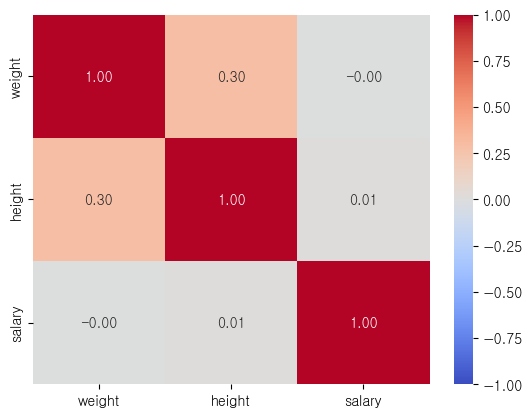

In [169]:
sns.heatmap(numericalDF.corr(), annot=True, cmap="coolwarm", vmax=1, vmin=-1, fmt = '.2f')
plt.show()

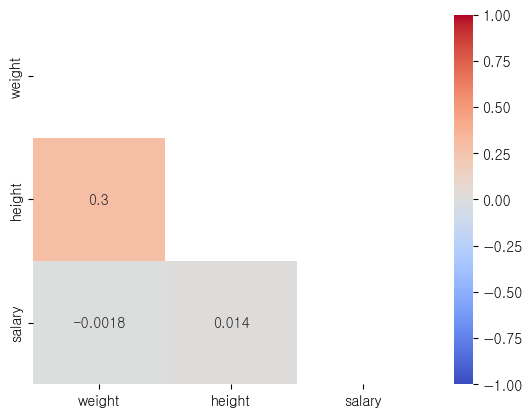

In [170]:
corr = numericalDF.corr()
mask = np.triu(np.ones_like(corr))
sns.heatmap(corr, annot=True, cmap="coolwarm", vmax=1, vmin=-1, mask = mask)
plt.show()

- 범주형 데이터 피처 간 상관계수

In [ ]:
df.baldDF.copy()
le = LabelEncoder()
for col in ['job_role', 'province', 'shampoo']:
    le.fit(df[col])
    df[col] = le.transform(df[col])

In [172]:
le.classes_

array([0, 1, 2, 3, 4])

In [173]:
categoricalDF = df[['age', 'gender', 'job_role', 'province', 'is_hereditary', 'shampoo', 'is_smoker', 'education', 'stress']]
categoricalDF.shape

(7175, 9)

In [174]:
# 이진 클래스를 갖는 피처들간의 상관계수 => 파이 상관계수 사용

df1 = categoricalDF[['gender', 'is_hereditary', 'is_smoker']]
for col1, col2 in combinations(df1.columns, 2):
    print(f'{col1}과 {col2}의 상관계수 {round(matthews_corrcoef(df1[col1].values, df1[col2].values), 3)}\n\n')

gender과 is_hereditary의 상관계수 -0.011


gender과 is_smoker의 상관계수 0.014


is_hereditary과 is_smoker의 상관계수 -0.018




In [175]:
rows= []
for col_name1 in df1:
    column = []
    for col_name2 in df1:
        phi = matthews_corrcoef(df1[col_name1], df1[col_name2])
        column.append(round(phi, 3))
    rows.append(column)
      
phi_results = np.array(rows)
phiDF = pd.DataFrame(phi_results, columns = df1.columns, index = df1.columns)
phiDF

,gender,is_hereditary,is_smoker
gender,1.000,-0.011,0.014
is_hereditary,-0.011,1.000,-0.018
is_smoker,0.014,-0.018,1.000


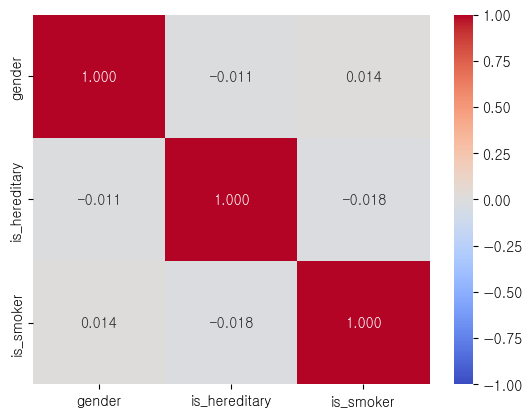

In [176]:
sns.heatmap(phiDF, annot = True, cmap = "coolwarm", vmax = 1, vmin = -1, fmt = '.3f')
plt.show()

In [177]:
# 다중 클래스를 갖는 피처들간의 상관계수 => 크래머 상관계수 사용

df2 = categoricalDF[['age', 'job_role', 'province', 'shampoo', 'education', 'stress']]
def cramers_V(col1, col2) :
    crosstab = np.array(pd.crosstab(col1, col2, rownames = None, colnames = None)) # Cross table building
    stat = chi2_contingency(crosstab)[0] # Keeping of the test statistic of the Chi2 test
    obs = np.sum(crosstab) # Number of observations
    phi2 = stat / obs
    r, k = crosstab.shape
    phi2corr = max(0, phi2 - (((k-1)*(r-1))/(obs - 1)))
    rcorr = r - ((r-1)**2)/(obs-1)
    kcorr = k - ((k-1)**2)/(obs-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

In [178]:
df2 = categoricalDF[['age', 'job_role', 'province', 'shampoo', 'education', 'stress']]
rows= []
for col_name1 in df2:
    column = []
    for col_name2 in df2:
        cramer = cramers_V(df2[col_name1], df2[col_name2]) # Cramer's V test
        column.append(round(cramer, 3)) # Keeping of the rounded value of the Cramer's V  
    rows.append(column)
      
cramers_results = np.array(rows)
cramerDF = pd.DataFrame(cramers_results, columns = df2.columns, index = df2.columns)
cramerDF

,age,job_role,province,shampoo,education,stress
age,1.000,0.025,0.000,0.000,0.000,0.000
job_role,0.025,1.000,0.021,0.000,0.000,0.000
province,0.000,0.021,1.000,0.029,0.015,0.000
shampoo,0.000,0.000,0.029,1.000,0.000,0.000
education,0.000,0.000,0.015,0.000,1.000,0.012
stress,0.000,0.000,0.000,0.000,0.012,1.000


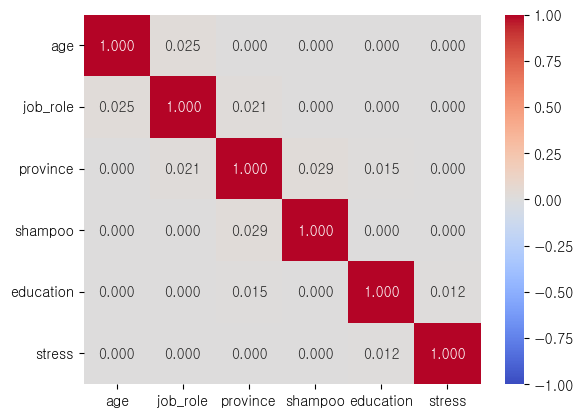

In [179]:
sns.heatmap(cramerDF, annot = True, cmap = "coolwarm", vmax = 1, vmin = -1, fmt = '.3f')
plt.show()

### 학습 진행 <hr>

In [180]:
baldDF.head()

,age,gender,job_role,province,salary,is_hereditary,weight,height,shampoo,is_smoker,education,stress,bald_prob
0,27,0,1,5,7.957453e+06,0,54.315053,170.428542,3,1,4,5,0.605974
1,53,0,1,3,7.633003e+06,0,72.873404,165.530097,3,0,4,7,0.532860
2,37,0,0,3,6.637625e+06,0,46.321533,154.599388,2,0,4,4,0.418442
3,36,0,2,22,3.624871e+06,0,51.539781,167.340481,0,1,1,9,0.804050
4,38,1,3,20,6.031808e+06,0,60.726909,165.514773,1,1,5,1,0.368371


In [192]:
# 지역, 샴푸 피처는 삭제
featureDF = baldDF.drop(['province', 'shampoo', 'bald_prob'], axis = 1)
targetSR = baldDF[baldDF.columns[-1]]

In [193]:
X_train, X_test, y_train, y_test = train_test_split(featureDF,
                                                    targetSR,
                                                    test_size = 0.2,
                                                    random_state = 10)

In [194]:
X_train.columns

Index(['age', 'gender', 'job_role', 'salary', 'is_hereditary', 'weight',
       'height', 'is_smoker', 'education', 'stress'],
      dtype='object')

In [195]:
baldDF.columns

Index(['age', 'gender', 'job_role', 'province', 'salary', 'is_hereditary',
       'weight', 'height', 'shampoo', 'is_smoker', 'education', 'stress',
       'bald_prob'],
      dtype='object')

In [196]:
ohe = OneHotEncoder(sparse = False)
ore = OrdinalEncoder()
std = StandardScaler()
ct = ColumnTransformer([('Ordinal', ore, ['job_role']),
                       ('StandardScaler', std, ['salary', 'weight', 'height'])],
                       remainder = 'passthrough')

new_column_list = ['job_role', 'salary', 'weight', 'height',
                   'age', 'gender','is_hereditary', 'is_smoker',
                   'education', 'stress'] 
ct.fit(X_train)
scaled_X_train = pd.DataFrame(ct.transform(X_train), columns = new_column_list)
scaled_X_test = pd.DataFrame(ct.transform(X_test), columns = new_column_list)

- 단일 모델로 성능 확인

In [197]:
xgbre = XGBRegressor(n_estimators = 100, learning_rate = 0.1, max_depth = 5, subsample = 1.0,
                     min_child_weight = 2, colsample_bytree = 0.5)
xgbre.fit(scaled_X_train, y_train)
y_preds = xgbre.predict(scaled_X_test)

In [198]:
print(f'Train Score => {xgbre.score(scaled_X_train, y_train)}\n')
print(f'Test Score => {xgbre.score(scaled_X_test, y_test)}')

Train Score => 0.8925678786113544

Test Score => 0.854409318971999


In [199]:
print(f'mean absolute error => {mean_absolute_error(y_preds, y_test)}\n')
print(f'mean squared error => {mean_squared_error(y_preds, y_test)}\n')
print(f'r2 score => {r2_score(y_preds, y_test)}')

mean absolute error => 0.04752820537464336

mean squared error => 0.00439825637873208

r2 score => 0.815692297429123


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

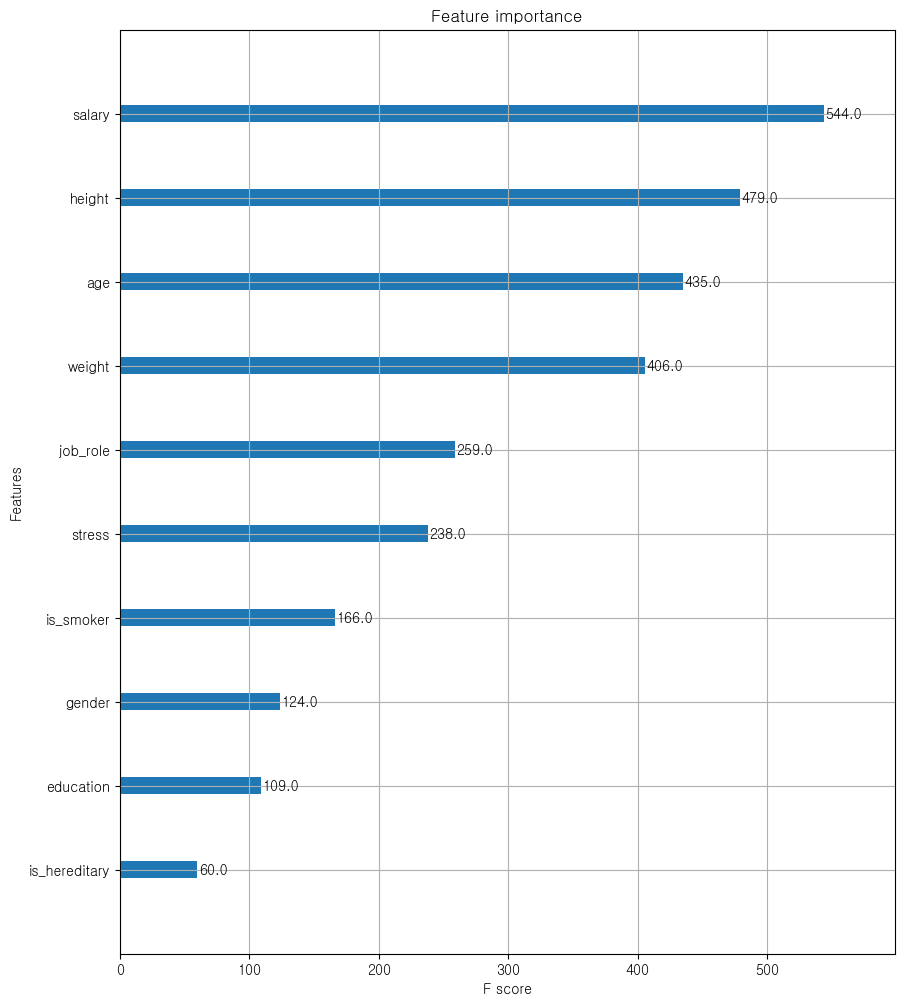

In [200]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgbre, ax=ax)

In [201]:
# 모델 조합 조건
# cv => 기본 5, max_depth, ..

xgb_model = XGBRegressor()
n_cv = 5
params = {'learning_rate' : [0.05, 0.1, 0.2],
        'max_depth' : [5, 6, 7, 8],
        'subsample' : [0.5, 1.0],
        'colsample_bytree' : [0.5, 1.0]
        }

# 하이퍼파라미터 조합된 모델 생성 후 교차검증 데이터셋으로 학습
# 진행해주는 인스턴스
gs = GridSearchCV(xgb_model, param_grid = params, cv = n_cv)

In [202]:
# 조합된 모델들의 학습 진행
result = gs.fit(X_train, y_train)

In [203]:
# 결과 확인
result

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             param_grid={'colsample_bytree': [0.5, 1.0],
                         'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [5, 6, 7, 8], 'subsample': [0.5, 1.0]})

In [204]:
gs.cv_results_

{'mean_fit_time': array([0.13282509, 0.14980383, 0.1559854 , 0.1705008 , 0.17960854,
        0.20209775, 0.22325034, 0.25584435, 0.13376546, 0.13645511,
        0.15909729, 0.18101664, 0.17622933, 0.20014462, 0.20808496,
        0.25673609, 0.14846935, 0.16326437, 0.16075382, 0.19694667,
        0.19884582, 0.21845713, 0.23713336, 0.24638786, 0.16115208,
        0.20093536, 0.19477863, 0.23759522, 0.25496674, 0.32750297,
        0.31109767, 0.38580546, 0.19720297, 0.21774693, 0.21124601,
        0.25209255, 0.25755553, 0.30426669, 0.30936899, 0.39078178,
        0.18533773, 0.21240854, 0.23440471, 0.29075594, 0.257021  ,
        0.29695983, 0.31232758, 0.37728949]),
 'std_fit_time': array([0.00300113, 0.01100984, 0.0084904 , 0.00739548, 0.01225495,
        0.01175355, 0.01096606, 0.01048073, 0.00724252, 0.00235476,
        0.01006643, 0.01325802, 0.00797379, 0.00419472, 0.00613347,
        0.00694978, 0.00808514, 0.00844749, 0.00543092, 0.02280724,
        0.01428648, 0.00824734, 0.021

In [205]:
# 학습 후 저장된 모델 파라미터 확인
# 교차학습 결과 => 조합된 모델의 개수만큼 결과 출력
cv_resultDF = pd.DataFrame(gs.cv_results_)

In [206]:
cv_resultDF

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_learning_rate,param_max_depth,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.132825,0.003001,0.006916,0.007142,0.5,0.05,5,0.5,"{'colsample_bytree': 0.5, 'learning_rate': 0.0...",0.812514,0.816416,0.845594,0.815449,0.863225,0.830640,0.020234,12
1,0.149804,0.011010,0.003068,0.006136,0.5,0.05,5,1.0,"{'colsample_bytree': 0.5, 'learning_rate': 0.0...",0.809958,0.815293,0.848604,0.816277,0.864080,0.830842,0.021496,11
2,0.155985,0.008490,0.003367,0.006496,0.5,0.05,6,0.5,"{'colsample_bytree': 0.5, 'learning_rate': 0.0...",0.806119,0.814601,0.845072,0.814696,0.861794,0.828456,0.021297,17
3,0.170501,0.007395,0.006462,0.007921,0.5,0.05,6,1.0,"{'colsample_bytree': 0.5, 'learning_rate': 0.0...",0.805478,0.813866,0.846265,0.813156,0.863691,0.828491,0.022510,16
4,0.179609,0.012255,0.000000,0.000000,0.5,0.05,7,0.5,"{'colsample_bytree': 0.5, 'learning_rate': 0.0...",0.799104,0.810536,0.839044,0.808537,0.857189,0.822882,0.021734,27
5,0.202098,0.011754,0.004188,0.007048,0.5,0.05,7,1.0,"{'colsample_bytree': 0.5, 'learning_rate': 0.0...",0.798704,0.809900,0.840394,0.807260,0.859789,0.823209,0.023089,26
6,0.223250,0.010966,0.006250,0.007654,0.5,0.05,8,0.5,"{'colsample_bytree': 0.5, 'learning_rate': 0.0...",0.793917,0.803743,0.831930,0.801978,0.849419,0.816197,0.021000,37
7,0.255844,0.010481,0.003208,0.004661,0.5,0.05,8,1.0,"{'colsample_bytree': 0.5, 'learning_rate': 0.0...",0.790491,0.805842,0.830945,0.801590,0.852170,0.816208,0.022329,36
8,0.133765,0.007243,0.000000,0.000000,0.5,0.1,5,0.5,"{'colsample_bytree': 0.5, 'learning_rate': 0.1...",0.817934,0.824145,0.853534,0.819131,0.871822,0.837313,0.021603,2
9,0.136455,0.002355,0.009376,0.007655,0.5,0.1,5,1.0,"{'colsample_bytree': 0.5, 'learning_rate': 0.1...",0.818351,0.820930,0.852601,0.822828,0.874406,0.837823,0.022118,1


In [207]:
# 조합된 모델 중 최고의 성능을 내는 하이퍼파라미터 값
gs.best_params_

{'colsample_bytree': 0.5,
 'learning_rate': 0.1,
 'max_depth': 5,
 'subsample': 1.0}

In [208]:
# 조합된 모델 중 최고의 성능을 내는 모델 인스턴스
my_best_model = gs.best_estimator_

In [209]:
# 조합된 모델 중 최고 점수
gs.best_score_

0.8378233927111998

In [210]:
# 모델 저장
model_dir = './model/'
model_filename = model_dir + 'bald_xgb.pkl'

# 저장 폴더 존재 여부 확인 후 저장
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

In [211]:
joblib.dump(my_best_model, model_filename)

['./model/bald_xgb.pkl']

In [212]:
model_file = './model/bald_xgb.pkl'

In [213]:
X_train.columns

Index(['age', 'gender', 'job_role', 'salary', 'is_hereditary', 'weight',
       'height', 'is_smoker', 'education', 'stress'],
      dtype='object')

In [214]:
import pandas as pd
import numpy as np

model = load(model_file)

data = input('알아서 입력하세요 : ')
if len(data):
    data_list = list(map(float, data.split(',')))  # 넣을 데이터에 컬럼명이 없으면 경고 메세지 뜬다.
    feature_name = ['age', 'gender', 'job_role', 'salary',
                    'is_hereditary', 'weight',
                    'height', 'is_smoker', 'education', 'stress']
    df = pd.DataFrame(dict(zip(feature_name, data_list)), index = [0])
    print(df)

    # 모델의 predict(2D)
    pre_prob = model.predict(df)
    #proba = np.round(np.max(model.predict_proba(df)[0]) * 100, 1)
    print(f'해당 데이터를 가진 사람이 hair loss일 확률은 {np.round(pre_prob*100, 2)}% 입니다.')
else:
    print('입력된 정보가 없습니다.')

    age  gender  job_role      salary  is_hereditary  weight  height  \
0  33.0     1.0       3.0  9451248.13            0.0    73.0   180.0   

   is_smoker  education  stress  
0        0.0        5.0     5.0  
해당 데이터를 가진 사람이 hair loss일 확률은 [35.61]% 입니다.
